## Credit Card Default Prediction — Data Understanding

This notebook explores a real-world credit default dataset.
The objective is to understand the structure of the data, identify
risk-related features, and prepare for ensemble modeling in later stages.


## Importing Libraries and Loading the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Display settings (optional)
pd.set_option("display.max_columns", None)

cd = pd.read_csv("../data/credit_default.csv")
cd.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [2]:
# Basic sanity checks
print("Shape:", cd.shape)
print("Missing values (total):", cd.isna().sum().sum())
print("Duplicate rows:", cd.duplicated().sum())

# ID should be unique (identifier, not a predictive feature)
if "ID" in cd.columns:
    print("Unique IDs:", cd["ID"].nunique())


Shape: (30000, 25)
Missing values (total): 0
Duplicate rows: 0
Unique IDs: 30000


## Dataset Overview

In [3]:
cd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [4]:
# Missingness per column (top 10)
missing = cd.isna().sum().sort_values(ascending=False)
missing[missing > 0].head(10)

Series([], dtype: int64)

- The dataset contains **30,000 rows and 25 columns**.
- There are **no missing values** across all features.
- Although most columns are numeric, several variables are **categorical or ordinal encoded as integers**
  (e.g., `SEX`, `EDUCATION`, `MARRIAGE`, `PAY_0`–`PAY_6`).
- The target variable is `default.payment.next.month` (binary: 1 = default, 0 = no default).
- The `ID` column is a unique identifier and will be **excluded from modeling**.


## Target Variable Analysis

,count,proportion
default.payment.next.month,,
0,23364,0.7788
1,6636,0.2212


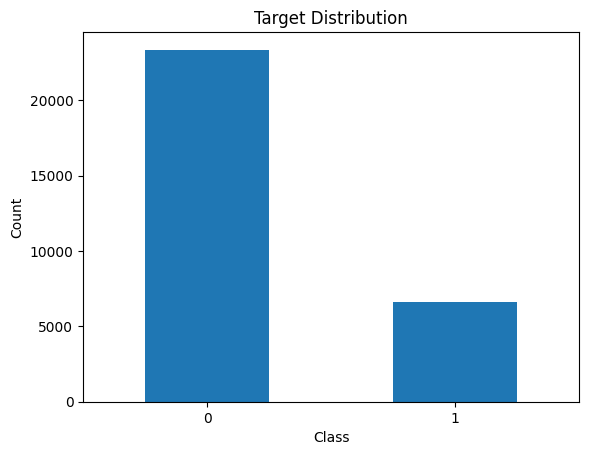

In [5]:
# Target distribution (0 = non-default, 1 = default)
target_col = "default.payment.next.month"
y_counts = cd[target_col].value_counts()
y_props = cd[target_col].value_counts(normalize=True)

display(pd.DataFrame({"count": y_counts, "proportion": y_props}))

# Visual check
y_counts.plot(kind="bar")
plt.title("Target Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


The target variable is binary and moderately imbalanced:

- Approximately **77.9%** of customers did not default
- Approximately **22.1%** of customers defaulted (minority class)

Due to this imbalance, **accuracy alone is not a reliable evaluation metric**.
Model performance should instead be assessed using ROC-AUC, precision, recall,
and F1-score. Class weighting or decision-threshold tuning may be required.

### Feature Groups

The dataset contains multiple groups of features:
- Demographic features (age, education, marital status)
- Credit limit information
- Payment history features
- Bill amount features
- Payment amount features

These groups capture different aspects of credit risk.


In [6]:
# Categorical-coded features: check value ranges and imbalance
cat_cols = [c for c in ["SEX", "EDUCATION", "MARRIAGE"] if c in cd.columns]

for col in cat_cols:
    vc = cd[col].value_counts(dropna=False).sort_index()
    print(f"\n{col} value counts:")
    print(vc)

# Note: EDUCATION and MARRIAGE sometimes include '0'/'5'/'6' codes (dataset-specific).
# Before modeling with one-hot encoding, consider grouping rare/unknown codes into 'Other/Unknown'.



SEX value counts:
SEX
1    11888
2    18112
Name: count, dtype: int64

EDUCATION value counts:
EDUCATION
0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: count, dtype: int64

MARRIAGE value counts:
MARRIAGE
0       54
1    13659
2    15964
3      323
Name: count, dtype: int64


## Numerical Feature Inspection

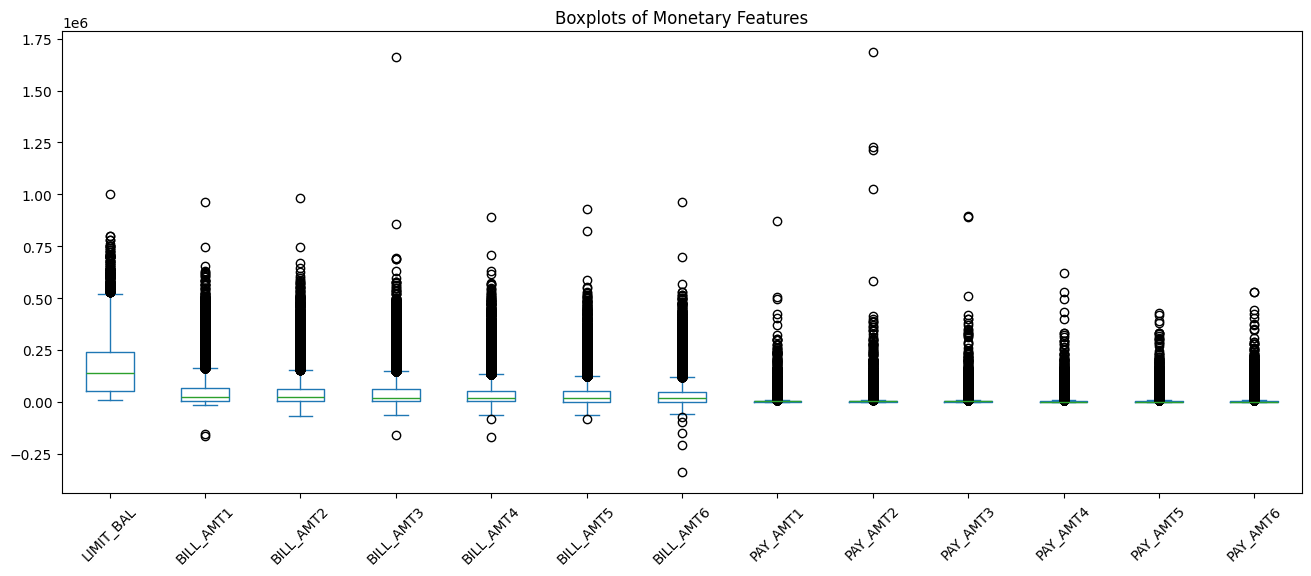

In [7]:
monetary_cols = [
    'LIMIT_BAL',
    'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
    'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6'
]

# Skewness > 1 → highly right-skewed
# Skewness between 0.5–1 → moderately skewed

cd[monetary_cols].skew().sort_values(ascending=False)

cd[monetary_cols].plot(kind='box', figsize=(16,6), rot=45)

plt.title("Boxplots of Monetary Features")
plt.show()

Summary statistics reveal substantial scale differences among monetary features
(`LIMIT_BAL`, `BILL_AMT*`, `PAY_AMT*`), with strong right-skewness and extreme
outliers.

Several integer-encoded variables (`SEX`, `EDUCATION`, `MARRIAGE`, `PAY_*`)
represent categorical or ordinal information; therefore, their means and
standard deviations are not interpreted as continuous measures.

These properties motivate feature scaling or log transformation for linear
models, while tree-based models are less sensitive to skewness and outliers.

### Class Imbalance Consideration

The target variable is imbalanced, with non-default cases forming the majority.
This means evaluation metrics such as recall and ROC AUC will be more informative
than accuracy alone.


### Why Single Models Are Risky

Single models such as Decision Trees are sensitive to noise and small changes
in data. This can lead to unstable predictions and overfitting.


### Ensemble Learning

Ensemble learning combines multiple models to produce more stable and
accurate predictions. By aggregating many weak learners, ensembles reduce
variance and improve generalization.


### Bagging vs Boosting

- Bagging (e.g., Random Forest): reduces variance by averaging many independent models.
- Boosting (e.g., Gradient Boosting): focuses on correcting previous model errors.

Both approaches aim to improve predictive performance but behave differently.


## Key Takeaways

- The dataset is clean and contains no missing values.
- The target variable is imbalanced, requiring careful metric selection.
- Monetary features are highly skewed with extreme outliers.
- The `ID` column must be dropped prior to modeling.
- These findings directly inform preprocessing and model selection decisions.
